<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Init-data" data-toc-modified-id="Init-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Init data</a></span><ul class="toc-item"><li><span><a href="#Estaciones" data-toc-modified-id="Estaciones-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Estaciones</a></span></li><li><span><a href="#Data-Mediciones" data-toc-modified-id="Data-Mediciones-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data Mediciones</a></span></li></ul></li><li><span><a href="#Predicción-de-Ozono-para-el-Valle-de-México" data-toc-modified-id="Predicción-de-Ozono-para-el-Valle-de-México-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Predicción de Ozono para el Valle de México</a></span><ul class="toc-item"><li><span><a href="#Por-estacion" data-toc-modified-id="Por-estacion-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Por estacion</a></span></li><li><span><a href="#Para-el-Valle-de-México-por-hora" data-toc-modified-id="Para-el-Valle-de-México-por-hora-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Para el Valle de México por hora</a></span></li><li><span><a href="#Valle-de-México-por-día" data-toc-modified-id="Valle-de-México-por-día-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Valle de México por día</a></span></li></ul></li></ul></div>

In [14]:
import pandas as pd
from joblib import Parallel, delayed
import numpy as np
import json
from pathlib import Path
import altair as alt
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet

from fbprophet import Prophet

pd.options.mode.chained_assignment = None

%matplotlib inline

# Init data

## Estaciones

In [15]:
estaciones = pd.read_csv('/data/calidad_aire_presidencia/data_estaciones_sinaica.csv')
mask = (estaciones.lat.between(14, 34.5)) & (estaciones.long.between(-120, -70))
estaciones = estaciones[mask].rename(columns={'id':'estacionesid'})

print(estaciones.shape)
estaciones.head()

(180, 8)


,_id,lat,long,estacionesid,nombre,codigo,redesid,date-insert
0,5b8850e3e2705c1932e82ff8,21.873311,-102.320803,31,CBTIS,CBT,30,2018-08-30 20:17:39.218
1,5b8850e3e2705c1932e82ff9,21.846392,-102.288431,32,Secretaría de Medio Ambiente,SMA,30,2018-08-30 20:17:39.218
2,5b8850e3e2705c1932e82ffa,21.883781,-102.295825,33,Centro,CEN,30,2018-08-30 20:17:39.218
3,5b8850e3e2705c1932e82ffb,31.859917,-116.593722,36,Secundaria,SPABC20,31,2018-08-30 20:17:39.218
4,5b8850e3e2705c1932e82ffc,32.631317,-115.444631,38,UABC,SPABC12,32,2018-08-30 20:17:39.218


## Data Mediciones

In [16]:
mediciones = pd.read_csv('/data/calidad_aire_presidencia/data_mediciones_todas_estaciones_2.csv')
print(mediciones.shape)
mediciones.head()

(3240000, 8)


,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig
0,Durango,58,2018-08-01,13,PM10,Durango,1,988.61
1,Durango,58,2018-08-01,14,PM10,Durango,1,988.61
2,Durango,58,2018-08-01,15,PM10,Durango,1,988.60
3,Durango,58,2018-08-01,16,PM10,Durango,1,988.63
4,Durango,58,2018-08-01,17,PM10,Durango,1,988.63


In [17]:
estaciones_ciudad = mediciones[['city', 'state', 'estacionesid']].drop_duplicates()
print(estaciones_ciudad.shape)
estaciones_ciudad.head()

(123, 3)


,city,state,estacionesid
0,Durango,Durango,58
6543,Durango,Durango,59
33554,Durango,Durango,60
65683,Gómez Palacio,Durango,65
80484,Celaya,Guanajuato,68


In [18]:
estaciones_ciudad.groupby('city').estacionesid.nunique().sort_values(ascending=False).head()

city
Valle de México    32
Monterrey          11
Guadalajara        10
Toluca              6
León                3
Name: estacionesid, dtype: int64

In [19]:
estaciones_ciudad[estaciones_ciudad.city=='Valle de México'].merge(estaciones)

,city,state,estacionesid,_id,lat,long,nombre,codigo,redesid,date-insert
0,Valle de México,Ciudad de México,242,5b8850e3e2705c1932e8306b,19.272222,-99.207778,Ajusco Medio,AJM,119,2018-08-30 20:17:39.225
1,Valle de México,Ciudad de México,243,5b8850e3e2705c1932e8306c,19.577222,-99.254167,Atizapán,ATI,119,2018-08-30 20:17:39.225
2,Valle de México,Ciudad de México,244,5b8850e3e2705c1932e8306d,19.468611,-99.170000,Camarones,CAM,119,2018-08-30 20:17:39.225
3,Valle de México,Ciudad de México,245,5b8850e3e2705c1932e8306e,19.326389,-99.176111,Centro de Ciencias de la Atmósfera,CCA,119,2018-08-30 20:17:39.225
4,Valle de México,Ciudad de México,248,5b8850e3e2705c1932e83071,19.365556,-99.291944,Cuajimalpa,CUA,119,2018-08-30 20:17:39.225
5,Valle de México,Ciudad de México,250,5b8850e3e2705c1932e83073,19.482500,-99.243611,FES Acatlán,FAC,119,2018-08-30 20:17:39.225
6,Valle de México,Ciudad de México,251,5b8850e3e2705c1932e83074,19.411667,-99.152222,Hospital General de México,HGM,119,2018-08-30 20:17:39.225
7,Valle de México,Ciudad de México,253,5b8850e3e2705c1932e83076,19.535000,-99.117778,La Presa,LPR,119,2018-08-30 20:17:39.225
8,Valle de México,Ciudad de México,256,5b8850e3e2705c1932e83078,19.424722,-99.119722,Merced,MER,119,2018-08-30 20:17:39.225
9,Valle de México,Ciudad de México,257,5b8850e3e2705c1932e83079,19.460417,-98.902861,Montecillo,MON,119,2018-08-30 20:17:39.225


# Predicción de Ozono para el Valle de México

In [20]:
ciudad = mediciones[(mediciones.city.isin(['Valle de México']))]
ciudad['fecha_hora']  = pd.to_datetime(ciudad.fecha + ' ' +
                                            ciudad.hora.astype(str) +':00:00')

ciudad['fecha'] = pd.to_datetime(ciudad.fecha)

ciudad['dia_semana'] = ciudad.fecha.dt.weekday_name

O3_valleMex = ciudad[(ciudad.parametro.isin(['O3']))]

O3_valleMex = O3_valleMex.sort_values('fecha_hora')
print(O3_valleMex.shape)
O3_valleMex.head()

(152281, 10)


,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig,fecha_hora,dia_semana
1891057,Valle de México,240,2018-01-01,0,O3,Ciudad de México,1,0.011,2018-01-01,Monday
2718294,Valle de México,301,2018-01-01,0,O3,Ciudad de México,1,0.038,2018-01-01,Monday
2052820,Valle de México,249,2018-01-01,0,O3,Ciudad de México,1,0.018,2018-01-01,Monday
2078440,Valle de México,250,2018-01-01,0,O3,Ciudad de México,1,0.026,2018-01-01,Monday
2104364,Valle de México,251,2018-01-01,0,O3,Ciudad de México,1,0.015,2018-01-01,Monday


## Por estacion

In [42]:
# centro de ciencias de la atmósfera: 245
# Pedregal: 259
ts_estacion = O3_valleMex[O3_valleMex.estacionesid==245]

ntest = 12

ts_test = ts_estacion[-ntest::][['fecha_hora', 'valororig']]
ts_test.columns = ['ds', 'y']

ts_estacion = ts_estacion[['fecha_hora', 'valororig']][0:-ntest]
ts_estacion.columns = ['ds', 'y']

# Vamos a llenar los valores donde no tenemos mediciones con la media por dia de la semana y hora
ts_estacion = ts_estacion.set_index('ds').resample('h').mean() # mediciones consecutivas por hora
ts_estacion['weekday'] = ts_estacion.index.weekday_name
ts_estacion['hora'] = ts_estacion.index.hour
# Con estos 
fillnas = ts_estacion.groupby(['weekday', 'hora']).transform('mean').y
ts_estacion['y'] = np.where(ts_estacion.y.isnull(), fillnas, ts_estacion.y)

ts_estacion = ts_estacion[['y']].reset_index()

print(ts_estacion.shape)
ts_estacion.head()

(5379, 2)


,ds,y
0,2018-01-23 01:00:00,0.018
1,2018-01-23 02:00:00,0.013
2,2018-01-23 03:00:00,0.007
3,2018-01-23 04:00:00,0.006
4,2018-01-23 05:00:00,0.006


/home/fickincool/anaconda3/envs/opi_py36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


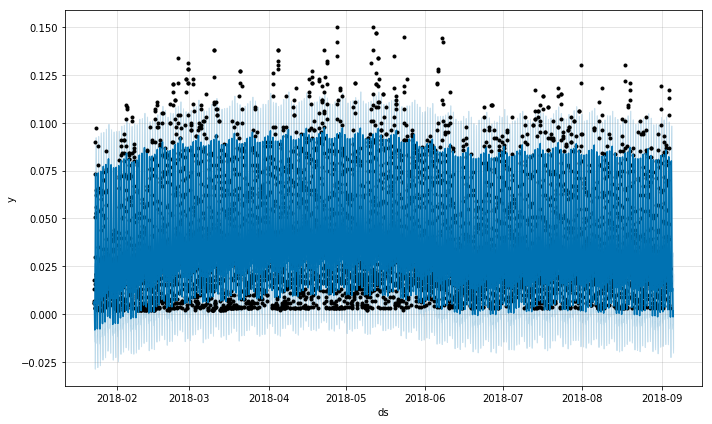

In [43]:
m = Prophet(yearly_seasonality=False).fit(ts_estacion)
future = m.make_future_dataframe(periods=30, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

In [44]:
errors = fcst.merge(ts_test, on='ds')
errors['RAE'] = abs(errors.y-errors.yhat)/errors.y
print(errors.shape)
errors

(12, 21)


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,seasonal,...,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat,y,RAE
0,2018-09-04 04:00:00,0.032815,0.032815,0.032815,-0.004623,0.033047,-0.017500,-0.017500,-0.017500,-0.019155,...,-0.019155,-0.019155,-0.019155,-0.019155,-0.001654,-0.001654,-0.001654,0.013660,0.017,0.196456
1,2018-09-04 05:00:00,0.032811,0.032811,0.032811,-0.007797,0.029714,-0.019947,-0.019947,-0.019947,-0.021675,...,-0.021675,-0.021675,-0.021675,-0.021675,-0.001728,-0.001728,-0.001728,0.011136,0.011,0.012361
2,2018-09-04 06:00:00,0.032807,0.032807,0.032807,-0.013322,0.024770,-0.024936,-0.024936,-0.024936,-0.026725,...,-0.026725,-0.026725,-0.026725,-0.026725,-0.001790,-0.001790,-0.001790,0.006082,0.008,0.239741
3,2018-09-04 07:00:00,0.032803,0.032803,0.032803,-0.016956,0.019601,-0.030154,-0.030154,-0.030154,-0.031994,...,-0.031994,-0.031994,-0.031994,-0.031994,-0.001840,-0.001840,-0.001840,0.000809,0.005,0.838129
4,2018-09-04 08:00:00,0.032800,0.032800,0.032800,-0.022407,0.017476,-0.032442,-0.032442,-0.032442,-0.034321,...,-0.034321,-0.034321,-0.034321,-0.034321,-0.001879,-0.001879,-0.001879,-0.001521,0.003,1.507076
5,2018-09-04 09:00:00,0.032796,0.032796,0.032796,-0.017090,0.020331,-0.029505,-0.029505,-0.029505,-0.031413,...,-0.031413,-0.031413,-0.031413,-0.031413,-0.001907,-0.001907,-0.001907,0.001383,0.006,0.769498
6,2018-09-04 10:00:00,0.032792,0.032792,0.032792,-0.009087,0.027363,-0.020866,-0.020866,-0.020866,-0.022793,...,-0.022793,-0.022793,-0.022793,-0.022793,-0.001926,-0.001926,-0.001926,0.009999,0.016,0.375038
7,2018-09-04 11:00:00,0.032788,0.032788,0.032788,0.005121,0.042393,-0.007648,-0.007648,-0.007648,-0.009584,...,-0.009584,-0.009584,-0.009584,-0.009584,-0.001936,-0.001936,-0.001936,0.023204,0.020,0.160182
8,2018-09-04 12:00:00,0.032784,0.032784,0.032784,0.020931,0.058711,0.008188,0.008188,0.008188,0.006250,...,0.006250,0.006250,0.006250,0.006250,-0.001938,-0.001938,-0.001938,0.039034,0.037,0.054983
9,2018-09-04 13:00:00,0.032780,0.032780,0.032780,0.035152,0.072846,0.024341,0.024341,0.024341,0.022408,...,0.022408,0.022408,0.022408,0.022408,-0.001933,-0.001933,-0.001933,0.055188,0.060,0.080198


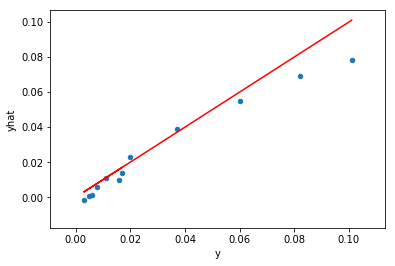

In [46]:
errors.plot.scatter('y', 'yhat')
plt.plot(errors.y, errors.y, color='red')

count    12.000000
mean      0.384873
std       0.440744
min       0.012361
25%       0.138183
50%       0.211877
75%       0.473653
max       1.507076
Name: RAE, dtype: float64

/home/fickincool/anaconda3/envs/opi_py36/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


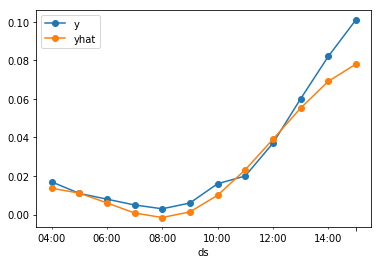

In [47]:
display(errors.RAE.describe())
errors.plot(x='ds', y=['y', 'yhat'], style='-o')

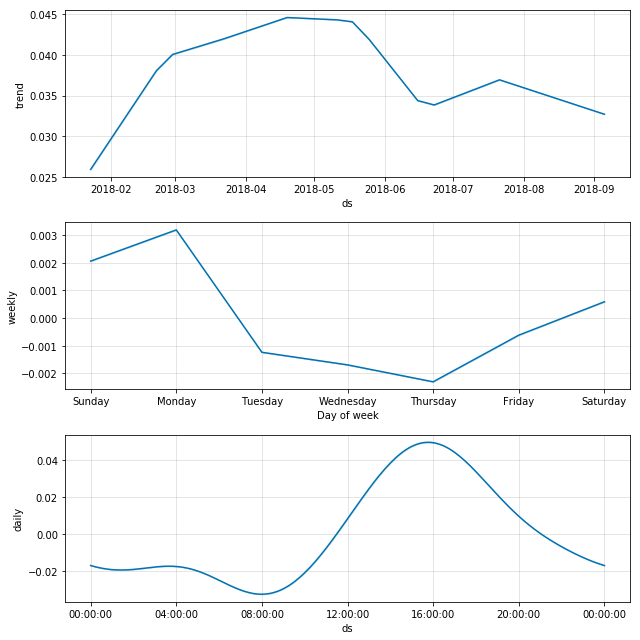

In [48]:
fig = m.plot_components(fcst)

## Para el Valle de México por hora

In [63]:
ts_estacion = O3_valleMex.groupby('fecha_hora').valororig.mean().reset_index()
ts_estacion['fecha_hora'] = pd.to_datetime(ts_estacion.fecha_hora)

ntest = 14

ts_test = ts_estacion[-ntest::][['fecha_hora', 'valororig']]
ts_test.columns = ['ds', 'y']

ts_estacion = ts_estacion[['fecha_hora', 'valororig']][0:-ntest]
ts_estacion.columns = ['ds', 'y']

# Vamos a llenar los valores donde no tenemos mediciones con la media por dia de la semana y hora
ts_estacion = ts_estacion.set_index('ds').resample('H').mean() # mediciones consecutivas por hora
ts_estacion['weekday'] = ts_estacion.index.weekday_name
ts_estacion['hora'] = ts_estacion.index.hour
# Con estos 
fillnas = ts_estacion.groupby(['weekday', 'hora']).transform('mean').y
ts_estacion['y'] = np.where(ts_estacion.y.isnull(), fillnas, ts_estacion.y)

ts_estacion = ts_estacion[['y']].reset_index()

print(ts_estacion.shape)
ts_estacion.head()

(5904, 2)


,ds,y
0,2018-01-01 00:00:00,0.016519
1,2018-01-01 01:00:00,0.019481
2,2018-01-01 02:00:00,0.020308
3,2018-01-01 03:00:00,0.018704
4,2018-01-01 04:00:00,0.017462


/home/fickincool/anaconda3/envs/opi_py36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


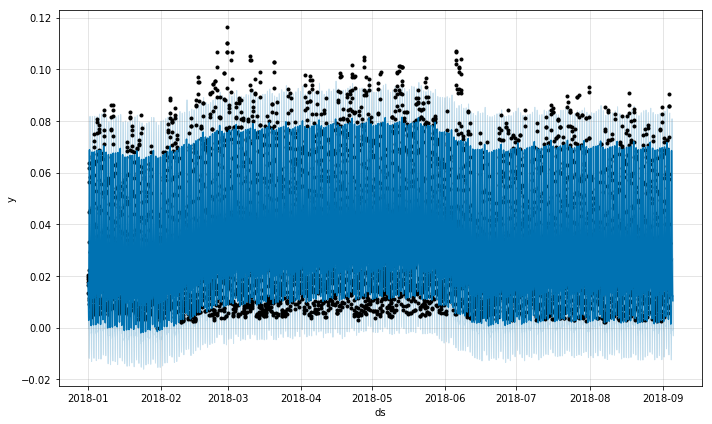

In [64]:
m = Prophet(yearly_seasonality=False).fit(ts_estacion)
future = m.make_future_dataframe(periods=30, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

In [65]:
errors = fcst.merge(ts_test, on='ds')
errors['RAE'] = abs(errors.y-errors.yhat)/errors.y
print(errors.shape)
errors

(14, 21)


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,seasonal,...,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat,y,RAE
0,2018-09-04 02:00:00,0.029460,0.029460,0.029460,-0.002057,0.025216,-0.016412,-0.016412,-0.016412,-0.017454,...,-0.017454,-0.017454,-0.017454,-0.017454,-0.001043,-0.001043,-0.001043,0.012006,0.014731,0.184983
1,2018-09-04 03:00:00,0.029459,0.029459,0.029459,-0.000113,0.023803,-0.016302,-0.016302,-0.016302,-0.017382,...,-0.017382,-0.017382,-0.017382,-0.017382,-0.001079,-0.001079,-0.001079,0.012078,0.016103,0.249993
2,2018-09-04 04:00:00,0.029459,0.029459,0.029459,-0.001509,0.025053,-0.016484,-0.016484,-0.016484,-0.017593,...,-0.017593,-0.017593,-0.017593,-0.017593,-0.001109,-0.001109,-0.001109,0.011866,0.013310,0.108537
3,2018-09-04 05:00:00,0.029458,0.029458,0.029458,-0.003962,0.022711,-0.018246,-0.018246,-0.018246,-0.019378,...,-0.019378,-0.019378,-0.019378,-0.019378,-0.001131,-0.001131,-0.001131,0.010080,0.011310,0.108771
4,2018-09-04 06:00:00,0.029457,0.029457,0.029457,-0.006454,0.019597,-0.021750,-0.021750,-0.021750,-0.022897,...,-0.022897,-0.022897,-0.022897,-0.022897,-0.001147,-0.001147,-0.001147,0.006559,0.007250,0.095242
5,2018-09-04 07:00:00,0.029456,0.029456,0.029456,-0.010100,0.015822,-0.025491,-0.025491,-0.025491,-0.026648,...,-0.026648,-0.026648,-0.026648,-0.026648,-0.001157,-0.001157,-0.001157,0.002808,0.003828,0.266277
6,2018-09-04 08:00:00,0.029455,0.029455,0.029455,-0.012323,0.014798,-0.026938,-0.026938,-0.026938,-0.028099,...,-0.028099,-0.028099,-0.028099,-0.028099,-0.001161,-0.001161,-0.001161,0.001356,0.003067,0.557718
7,2018-09-04 09:00:00,0.029454,0.029454,0.029454,-0.009584,0.017813,-0.023935,-0.023935,-0.023935,-0.025094,...,-0.025094,-0.025094,-0.025094,-0.025094,-0.001160,-0.001160,-0.001160,0.004360,0.004645,0.061378
8,2018-09-04 10:00:00,0.029454,0.029454,0.029454,-0.001117,0.025629,-0.015854,-0.015854,-0.015854,-0.017008,...,-0.017008,-0.017008,-0.017008,-0.017008,-0.001153,-0.001153,-0.001153,0.012446,0.011387,0.092990
9,2018-09-04 11:00:00,0.029453,0.029453,0.029453,0.011529,0.037917,-0.003803,-0.003803,-0.003803,-0.004946,...,-0.004946,-0.004946,-0.004946,-0.004946,-0.001143,-0.001143,-0.001143,0.024507,0.019759,0.240315


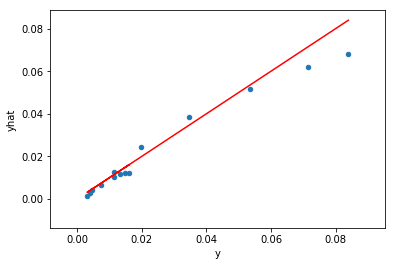

In [66]:
errors.plot.scatter('y', 'yhat')
plt.plot(errors.y, errors.y, color='red')

count    14.000000
mean      0.173544
std       0.131879
min       0.034333
25%       0.097854
50%       0.121155
75%       0.227699
max       0.557718
Name: RAE, dtype: float64

/home/fickincool/anaconda3/envs/opi_py36/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


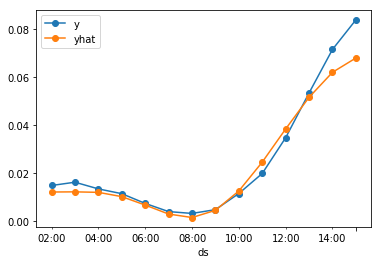

In [67]:
display(errors.RAE.describe())
errors.plot(x='ds', y=['y', 'yhat'], style='-o')

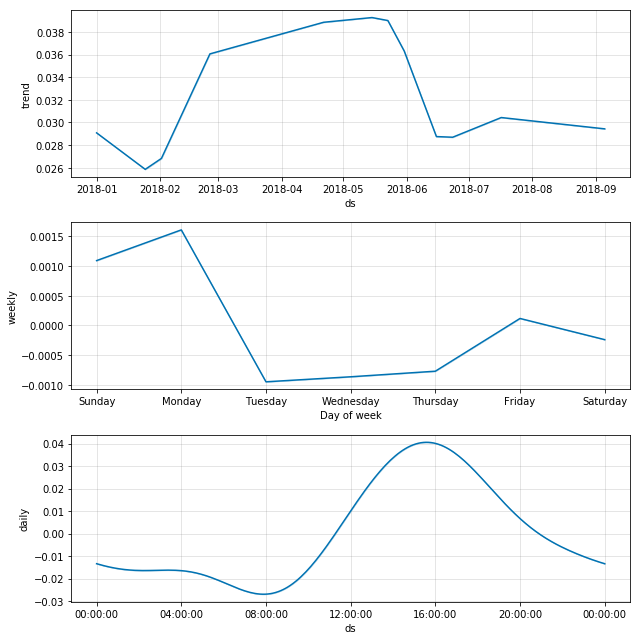

In [68]:
fig = m.plot_components(fcst)

## Valle de México por día

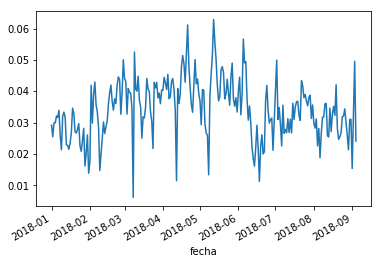

In [81]:
O3_valleMex.groupby('fecha').valororig.mean().plot()

In [73]:
ts_estacion = O3_valleMex.groupby('fecha').valororig.mean().reset_index()
ts_estacion['fecha'] = pd.to_datetime(ts_estacion.fecha)

ntest = 14

ts_test = ts_estacion[-ntest::][['fecha', 'valororig']]
ts_test.columns = ['ds', 'y']

ts_estacion = ts_estacion[['fecha', 'valororig']][0:-ntest]
ts_estacion.columns = ['ds', 'y']

# Vamos a llenar los valores donde no tenemos mediciones con la media por dia de la semana
ts_estacion = ts_estacion.set_index('ds').resample('d').mean() # mediciones consecutivas por dia
ts_estacion['weekday'] = ts_estacion.index.weekday_name
# Con estos 
fillnas = ts_estacion.groupby(['weekday']).transform('mean').y
ts_estacion['y'] = np.where(ts_estacion.y.isnull(), fillnas, ts_estacion.y)

ts_estacion = ts_estacion[['y']].reset_index()

print(ts_estacion.shape)
ts_estacion.head()

(232, 2)


,ds,y
0,2018-01-01,0.029215
1,2018-01-02,0.025511
2,2018-01-03,0.029973
3,2018-01-04,0.029952
4,2018-01-05,0.032157


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/fickincool/anaconda3/envs/opi_py36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


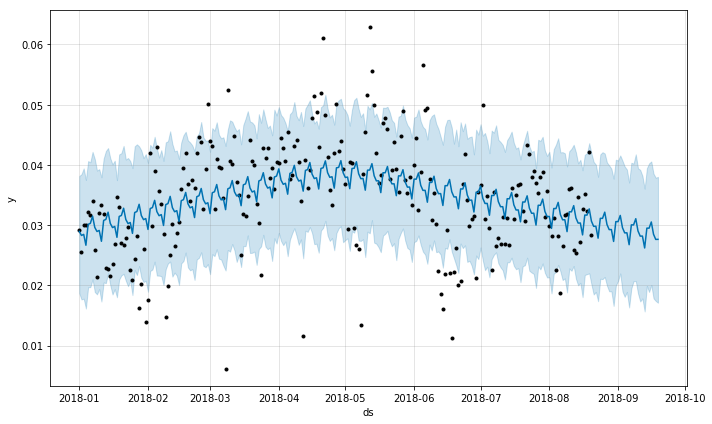

In [75]:
m = Prophet(yearly_seasonality=False).fit(ts_estacion)
future = m.make_future_dataframe(periods=30, freq='D')
fcst = m.predict(future)
fig = m.plot(fcst)

In [76]:
errors = fcst.merge(ts_test, on='ds')
errors['RAE'] = abs(errors.y-errors.yhat)/errors.y
print(errors.shape)
errors

(14, 18)


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat,y,RAE
0,2018-08-21,0.030513,0.030513,0.030513,0.018477,0.040512,-0.000713,-0.000713,-0.000713,-0.000713,-0.000713,-0.000713,-0.000713,-0.000713,-0.000713,0.029800,0.024729,0.205053
1,2018-08-22,0.030436,0.030436,0.030436,0.018916,0.040045,-0.000625,-0.000625,-0.000625,-0.000625,-0.000625,-0.000625,-0.000625,-0.000625,-0.000625,0.029811,0.025403,0.173516
2,2018-08-23,0.030358,0.030356,0.030360,0.017362,0.038032,-0.002523,-0.002523,-0.002523,-0.002523,-0.002523,-0.002523,-0.002523,-0.002523,-0.002523,0.027835,0.026798,0.038703
3,2018-08-24,0.030281,0.030274,0.030288,0.021100,0.041750,0.000849,0.000849,0.000849,0.000849,0.000849,0.000849,0.000849,0.000849,0.000849,0.031130,0.031821,0.021738
4,2018-08-25,0.030203,0.030191,0.030218,0.021035,0.042113,0.000919,0.000919,0.000919,0.000919,0.000919,0.000919,0.000919,0.000919,0.000919,0.031122,0.032156,0.032142
5,2018-08-26,0.030125,0.030108,0.030147,0.021393,0.041901,0.002028,0.002028,0.002028,0.002028,0.002028,0.002028,0.002028,0.002028,0.002028,0.032154,0.034396,0.065185
6,2018-08-27,0.030048,0.030024,0.030079,0.019950,0.040407,0.000064,0.000064,0.000064,0.000064,0.000064,0.000064,0.000064,0.000064,0.000064,0.030112,0.030360,0.008166
7,2018-08-28,0.029970,0.029938,0.030011,0.019008,0.039920,-0.000713,-0.000713,-0.000713,-0.000713,-0.000713,-0.000713,-0.000713,-0.000713,-0.000713,0.029257,0.026051,0.123060
8,2018-08-29,0.029893,0.029853,0.029943,0.019000,0.039385,-0.000625,-0.000625,-0.000625,-0.000625,-0.000625,-0.000625,-0.000625,-0.000625,-0.000625,0.029268,0.021366,0.369845
9,2018-08-30,0.029815,0.029765,0.029874,0.016575,0.037714,-0.002523,-0.002523,-0.002523,-0.002523,-0.002523,-0.002523,-0.002523,-0.002523,-0.002523,0.027292,0.031030,0.120443


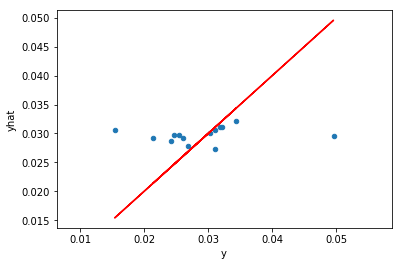

In [77]:
errors.plot.scatter('y', 'yhat')
plt.plot(errors.y, errors.y, color='red')

count    14.000000
mean      0.196565
std       0.259419
min       0.008166
25%       0.033782
50%       0.121751
75%       0.201354
max       0.985190
Name: RAE, dtype: float64

/home/fickincool/anaconda3/envs/opi_py36/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


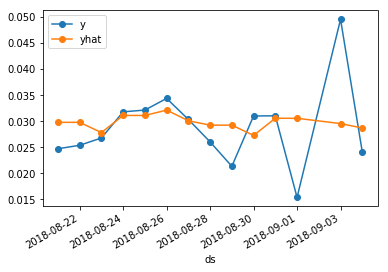

In [78]:
display(errors.RAE.describe())
errors.plot(x='ds', y=['y', 'yhat'], style='-o')

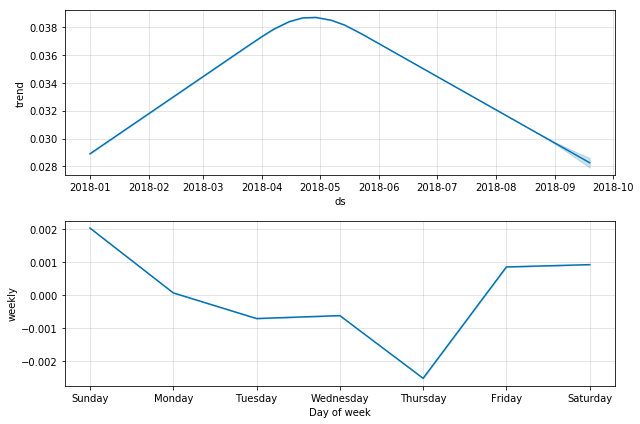

In [79]:
fig = m.plot_components(fcst)